**Part a)** The first part is to split the data into three sets: training, validation, and test. Split each class separately so that there is an equal percentage of each class in all three sets. The number of total images in the validation is to be roughly 2000, in the test set 3000, and the remainder for the training set. It does not need to be exact. This is called a stratified split.

In [3]:
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import torch.optim as optim
from ResNet import ResNet

from sklearn.metrics import accuracy_score, average_precision_score

import matplotlib.pyplot as plt
import pandas as pd

device = torch.device('cuda') if torch.cuda.is_available else 'cpu'

First, we decide the classes. `.parts[-1]` gets out the last part in the directory, whilst `.iterdir()` iterates through directories, and `.is_dir()` sees to it, that it really is a directory.

In [26]:
dataset = Path('/mnt/e/ml_projects/IN3310/2025/tut_data/mandatory1_data/')

classes = [str(subdir.parts[-1]) for subdir in dataset.iterdir() if subdir.is_dir()]
classes

['forest', 'buildings', 'sea', 'glacier', 'mountain', 'street']

Then, we create directories for `train, val, test` in the root folder

In [5]:
base_path = Path('/mnt/e/ml_projects/IN3310/2025/tut_data/oblig1/')

# the directories we want to create
dirs = ['train', 'val', 'test']

for dir_name in dirs:
    # creating a path string
    dir_path = base_path / dir_name
    dir_path.mkdir(parents=True, exist_ok=True) # creating directory

    # creating subdirectories of class names
    for class_name in classes:
        class_path = base_path / dir_name / class_name
        class_path.mkdir(parents=True, exist_ok=True)

Now we need to split the data into train, test, vals. A good way of doing this is to use `train_test_split` of the filenames and classes, and then fill our folders up.

In [6]:
img_paths = [] # container for image paths
class_indices = [] # container for class indices

for class_index, class_name in enumerate(classes):
    class_path = dataset / class_name
    for img_file in class_path.iterdir():
        if img_file.is_file():
            img_paths.append(img_file)
            class_indices.append(class_index)

In [7]:
train_imgs, temp_imgs, train_indices, temp_indices = train_test_split(
    img_paths, class_indices, test_size=0.3, stratify=class_indices, random_state=42
)

In [8]:
val_imgs, test_imgs, val_indices, test_indices = train_test_split(
    temp_imgs, temp_indices, test_size=0.6, stratify=temp_indices, random_state=42
)

In [9]:
def copy_images(img_paths, class_indices, split_name):
    
    for img_path, class_index in zip(img_paths, class_indices):
        target_dir = base_path / split_name / classes[class_index]
        target_file = target_dir / img_path.name

        # copying the file if it's not already there
        if not target_file.exists():
            shutil.copy(img_path, target_file)

In [10]:
copy_images(train_imgs, train_indices, 'train')
copy_images(val_imgs, val_indices, 'val')
copy_images(test_imgs, test_indices, 'test')

We now have folders with the data. Finally we can do a check for duplicates.

**Part b)** Create a solution to verify that the dataset splits are disjoint. Ensure that no file appears in more than one of your training, validation, or
test sets.

In [11]:
def verify_no_duplicates(train_imgs, val_imgs, test_imgs):
    train_set = set(train_imgs)
    val_set = set(val_imgs)
    test_set = set(test_imgs)

    # using intersection to check for data overlaps
    assert len(train_set.intersection(val_set)) == 0, 'Overlap between Train and Val'
    assert len(train_set.intersection(test_set)) == 0, 'Overlap between Train and Test'
    assert len(val_set.intersection(test_set)) == 0, 'Overlap between Val and Test'

verify_no_duplicates(train_imgs, val_imgs, test_imgs)

**Part c)** Develop and implement dataloaders for training, validation, and test sets. Please make one root path for the dataset, this makes it easier for us
to check/debug your work. If there are multiple paths to the dataset that we need to change, it becomes tricky to change them all.

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Endrer størrelse
    transforms.ToTensor(),  # Konverterer til PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisering for RGB-bilder
])

augment_transform = transforms.Compose([
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),  # Cropping og resizing
    transforms.RandomHorizontalFlip(p=0.5),  # 50% sjanse for speiling
    transforms.RandomRotation(15),  # Rotasjon ±15 grader
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Farger
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisering for RGB-bilder
])


In [12]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(), # converts to a torch tensor
    transforms.Normalize((0.5,), (0.5,)) # normalizes to [-1, 1]
])

# data augmentation parameters
augment_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(p=0.5),  # flipping image (P=50%)
    transforms.RandomRotation(15),  # rotating ±15 degrees
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),  # cropping randomly and scaling
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # changing colors
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  
])

In [13]:
train_dataset = datasets.ImageFolder(root=base_path / 'train', transform=transform)
train_dataset_augm = datasets.ImageFolder(root=base_path / 'train', transform=augment_transform)
val_dataset = datasets.ImageFolder(root=base_path / 'val', transform=transform)
test_dataset = datasets.ImageFolder(root=base_path / 'test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_loader_augm = DataLoader(train_dataset_augm, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

2b) Use the dataloaders you created in Part 1 to feed
the training data into the model of your choosing. Write code to perform the training process, ensuring that the model is optimized over the training data. Make sure to use the validation dataset to monitor performance during training. During training, monitor the model’s performance using accuracy on the validation set. This will give you an initial indication of how well your model is learning.

In [14]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

    val_loss = running_loss / len(dataloader)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_probs = torch.cat(all_probs)

    accuracy = accuracy_score(all_labels, all_preds)

    ap_scores = []
    class_accs = []
    num_classes = all_probs.shape[1]

    for i in range(all_probs.shape[1]):
        binary_labels = (all_labels == i).float()
        ap = average_precision_score(binary_labels.cpu().numpy(), all_probs[:, i].cpu().numpy())
        ap_scores.append(ap)

        class_correct = ((all_preds == i) & (all_labels == i)).sum().item()
        class_total = (all_labels == i).sum().item()
        class_accuracy = class_correct / class_total if class_total > 0 else 0
        class_accs.append(class_accuracy)

    map_score = sum(ap_scores) / len(ap_scores)

    return accuracy, val_loss, map_score, class_accs

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, file_path, num_epochs=10, early_stopping=5):
    model = model.to(device)

    train_accs, val_accs, map_scores, class_accs = [], [], [], []
    train_losses, val_losses = [], []
    best_map_score = 0.0
    epochs_no_improvement = 0

    for epoch in range(num_epochs):
        model.train()  # Treningsmodus
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        val_accuracy, val_loss, map_score, class_acc = evaluate_model(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        map_scores.append(map_score)
        class_accs.append(class_acc)

        if map_score > best_map_score:
            torch.save(model.state_dict(), file_path)
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, mAP: {map_score:.4f} - Model Saved")
            best_map_score = map_score
            epochs_no_improvement = 0

        else:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, mAP: {map_score:.4f}")
            epochs_no_improvement += 1

        if epochs_no_improvement > early_stopping:
            print("Early stopping!")
            break

    return train_accs, val_accs, map_scores, class_accs, train_losses, val_losses


In [16]:
criterion = nn.CrossEntropyLoss()
model = ResNet(img_channels=3, num_layers=34, num_classes=len(classes))
optimizer = optim.Adam(model.parameters(), lr=0.001)
file_path = '/mnt/e/ml_projects/IN3310/2025/tut_data/oblig1/resnet1.pth'
train_acc1, val_acc1, map_scores1, class_accs1, train_losses1, val_losses1 = train_model(model, train_loader, val_loader, criterion, optimizer, file_path, num_epochs=15)

Epoch 1/15, Train Loss: 1.0498, Val Loss: 0.9178, Train Acc: 0.5889, Val Acc: 0.6864, mAP: 0.7631 - Model Saved
Epoch 2/15, Train Loss: 0.7517, Val Loss: 0.7694, Train Acc: 0.7246, Val Acc: 0.7329, mAP: 0.8007 - Model Saved
Epoch 3/15, Train Loss: 0.6204, Val Loss: 0.7517, Train Acc: 0.7756, Val Acc: 0.7226, mAP: 0.8198 - Model Saved
Epoch 4/15, Train Loss: 0.5581, Val Loss: 0.8407, Train Acc: 0.7984, Val Acc: 0.7148, mAP: 0.8512 - Model Saved
Epoch 5/15, Train Loss: 0.5155, Val Loss: 0.5498, Train Acc: 0.8140, Val Acc: 0.7979, mAP: 0.8901 - Model Saved
Epoch 6/15, Train Loss: 0.4716, Val Loss: 0.4670, Train Acc: 0.8290, Val Acc: 0.8332, mAP: 0.9024 - Model Saved
Epoch 7/15, Train Loss: 0.4413, Val Loss: 0.4525, Train Acc: 0.8424, Val Acc: 0.8420, mAP: 0.9149 - Model Saved
Epoch 8/15, Train Loss: 0.4115, Val Loss: 0.4665, Train Acc: 0.8547, Val Acc: 0.8283, mAP: 0.9069
Epoch 9/15, Train Loss: 0.3987, Val Loss: 0.4295, Train Acc: 0.8613, Val Acc: 0.8527, mAP: 0.9215 - Model Saved
Epoch 

In [17]:
criterion = nn.CrossEntropyLoss()
model = ResNet(img_channels=3, num_layers=34, num_classes=len(classes))
optimizer = optim.Adam(model.parameters(), lr=0.001)
file_path = '/mnt/e/ml_projects/IN3310/2025/tut_data/oblig1/resnet2.pth'
train_acc2, val_acc2, map_scores2, class_accs2, train_losses2, val_losses2 = train_model(model, train_loader_augm, val_loader, criterion, optimizer, file_path, num_epochs=15)

Epoch 1/15, Train Loss: 1.2147, Val Loss: 0.9627, Train Acc: 0.5077, Val Acc: 0.6159, mAP: 0.6922 - Model Saved
Epoch 2/15, Train Loss: 0.9380, Val Loss: 0.7648, Train Acc: 0.6446, Val Acc: 0.7138, mAP: 0.8032 - Model Saved
Epoch 3/15, Train Loss: 0.7945, Val Loss: 0.6189, Train Acc: 0.7064, Val Acc: 0.7710, mAP: 0.8567 - Model Saved
Epoch 4/15, Train Loss: 0.6960, Val Loss: 0.6976, Train Acc: 0.7465, Val Acc: 0.7515, mAP: 0.8499
Epoch 5/15, Train Loss: 0.6355, Val Loss: 0.8206, Train Acc: 0.7684, Val Acc: 0.6947, mAP: 0.8465
Epoch 6/15, Train Loss: 0.6011, Val Loss: 0.7357, Train Acc: 0.7785, Val Acc: 0.7397, mAP: 0.8454
Epoch 7/15, Train Loss: 0.5812, Val Loss: 0.7035, Train Acc: 0.7914, Val Acc: 0.7387, mAP: 0.8701 - Model Saved
Epoch 8/15, Train Loss: 0.5410, Val Loss: 0.7083, Train Acc: 0.8051, Val Acc: 0.7417, mAP: 0.8513
Epoch 9/15, Train Loss: 0.5221, Val Loss: 0.4557, Train Acc: 0.8156, Val Acc: 0.8386, mAP: 0.9188 - Model Saved
Epoch 10/15, Train Loss: 0.5034, Val Loss: 0.436

In [19]:
criterion = nn.CrossEntropyLoss()
model = ResNet(img_channels=3, num_layers=34, num_classes=len(classes))
optimizer = optim.SGD(model.parameters(), lr=0.001)
file_path = '/mnt/e/ml_projects/IN3310/2025/tut_data/oblig1/resnet3.pth'
train_acc3, val_acc3, map_scores3, class_accs3, train_losses3, val_losses3 = train_model(model, train_loader, val_loader, criterion, optimizer, file_path, num_epochs=15)

Epoch 1/15, Train Loss: 1.2068, Val Loss: 1.0496, Train Acc: 0.5183, Val Acc: 0.5871, mAP: 0.6769 - Model Saved
Epoch 2/15, Train Loss: 0.8068, Val Loss: 1.7209, Train Acc: 0.6960, Val Acc: 0.5298, mAP: 0.6253
Epoch 3/15, Train Loss: 0.6470, Val Loss: 0.8543, Train Acc: 0.7635, Val Acc: 0.6844, mAP: 0.8011 - Model Saved
Epoch 4/15, Train Loss: 0.5485, Val Loss: 1.4463, Train Acc: 0.8024, Val Acc: 0.5920, mAP: 0.7419
Epoch 5/15, Train Loss: 0.4805, Val Loss: 0.7053, Train Acc: 0.8294, Val Acc: 0.7471, mAP: 0.8292 - Model Saved
Epoch 6/15, Train Loss: 0.4227, Val Loss: 0.5077, Train Acc: 0.8504, Val Acc: 0.8229, mAP: 0.8959 - Model Saved
Epoch 7/15, Train Loss: 0.3740, Val Loss: 0.5565, Train Acc: 0.8698, Val Acc: 0.8072, mAP: 0.8936
Epoch 8/15, Train Loss: 0.3276, Val Loss: 0.7803, Train Acc: 0.8874, Val Acc: 0.7383, mAP: 0.8631
Epoch 9/15, Train Loss: 0.2855, Val Loss: 0.5595, Train Acc: 0.9032, Val Acc: 0.8131, mAP: 0.8974 - Model Saved
Epoch 10/15, Train Loss: 0.2404, Val Loss: 0.507

In [20]:
criterion = nn.CrossEntropyLoss()
model = ResNet(img_channels=3, num_layers=34, num_classes=len(classes))
optimizer = optim.Adam(model.parameters(), lr=0.005)
file_path = '/mnt/e/ml_projects/IN3310/2025/tut_data/oblig1/resnet1.pth'
train_acc4, val_acc4, map_scores4, class_accs4, train_losses4, val_losses4 = train_model(model, train_loader, val_loader, criterion, optimizer, file_path, num_epochs=15)

Epoch 1/15, Train Loss: 1.2723, Val Loss: 1.0632, Train Acc: 0.4838, Val Acc: 0.5602, mAP: 0.6107 - Model Saved
Epoch 2/15, Train Loss: 0.9811, Val Loss: 0.9247, Train Acc: 0.6038, Val Acc: 0.6199, mAP: 0.7106 - Model Saved
Epoch 3/15, Train Loss: 0.8322, Val Loss: 0.7114, Train Acc: 0.6774, Val Acc: 0.7285, mAP: 0.8057 - Model Saved
Epoch 4/15, Train Loss: 0.7009, Val Loss: 0.7451, Train Acc: 0.7394, Val Acc: 0.7260, mAP: 0.8361 - Model Saved
Epoch 5/15, Train Loss: 0.6158, Val Loss: 0.5640, Train Acc: 0.7762, Val Acc: 0.7975, mAP: 0.8758 - Model Saved
Epoch 6/15, Train Loss: 0.5562, Val Loss: 0.5305, Train Acc: 0.7986, Val Acc: 0.8087, mAP: 0.8901 - Model Saved
Epoch 7/15, Train Loss: 0.5089, Val Loss: 0.6970, Train Acc: 0.8129, Val Acc: 0.7441, mAP: 0.8529
Epoch 8/15, Train Loss: 0.4616, Val Loss: 0.5070, Train Acc: 0.8313, Val Acc: 0.8200, mAP: 0.8961 - Model Saved
Epoch 9/15, Train Loss: 0.4330, Val Loss: 0.4760, Train Acc: 0.8443, Val Acc: 0.8312, mAP: 0.9099 - Model Saved
Epoch 

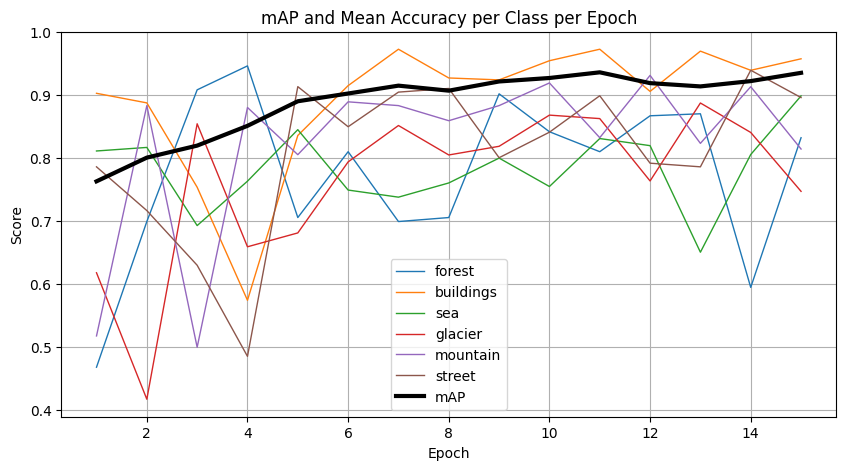

In [18]:
plt.figure(figsize=(10, 5))

# plotting accuracy per class
for i, cls in enumerate(classes):
    acc_per_class = [epoch[i] for epoch in class_accs1]
    plt.plot(range(1, len(acc_per_class) + 1), acc_per_class, linestyle='-', linewidth=1, label=f"{cls}")

# plotting mAP
plt.plot(range(1, len(map_scores1) + 1), map_scores1, linestyle='-', linewidth=3, color='black', label="mAP")

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("mAP and Mean Accuracy per Class per Epoch")
plt.legend()
plt.grid(True)
plt.show()


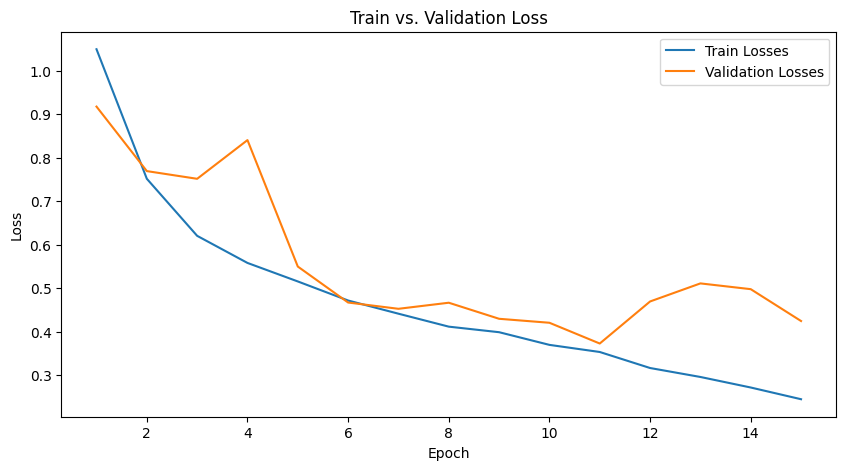

In [ ]:
# plotting train vs validation losses

epochs = range(1, len(train_acc1) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses1, label="Train Losses")
plt.plot(epochs, val_losses1, label="Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Validation Loss")
plt.legend()
plt.show()

In [27]:
import pandas as pd
import torch.nn.functional as F

SOFTMAX_CSV = "saved_softmax_scores.csv"
MODEL_PATH = '/mnt/e/ml_projects/IN3310/2025/tut_data/oblig1/resnet1.pth'

def predict(model, test_loader, file_path):
    model.eval()
    softmaxes = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            softmax_scores = F.softmax(outputs, dim=1).cpu().numpy()

            for label, scores in zip(labels.cpu().numpy(), softmax_scores):
                softmaxes.append([label] + scores.tolist())

    columns = ["label"] + [f"class_{i}" for i in range(softmax_scores.shape[1])]
    df = pd.DataFrame(softmaxes, columns=columns)
    df.to_csv(file_path, index=False)

    print(f"Softmax scores saved to {file_path}")

In [28]:
import numpy as np

def compare_softmax(file_path, model, test_loader, tolerance=1e-5):
    df = pd.read_csv(file_path)
    saved_labels = df["label"].values
    saved_softmax_scores = df.drop(columns=["label"]).values

    model.eval()
    all_softmax_scores = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            softmax_scores = F.softmax(outputs, dim=1).cpu().numpy()

            all_softmax_scores.append(softmax_scores)
            all_labels.append(labels.cpu().numpy())

    all_softmax_scores = np.concatenate(all_softmax_scores, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    is_close = np.allclose(saved_softmax_scores, all_softmax_scores, atol=tolerance)

    if is_close:
        print("Softmax scores match within the given tolerance.")
    else:
        print("Warning! Softmax scores do not match.")

    return is_close

In [29]:
def evaluate_on_test_set(model, test_loader):
    accuracy, test_loss, map_score, class_accs = evaluate_model(model, test_loader, criterion)
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test mAP: {map_score:.4f}")
    print(f"Test Mean Accuracy per Class: {np.mean(class_accs):.4f}")

    return accuracy, test_loss, map_score, class_accs


In [30]:
model = ResNet(img_channels=3, num_layers=34, num_classes=len(classes))
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)

predict(model, test_loader, SOFTMAX_CSV)
evaluate_on_test_set(model, test_loader)
compare_softmax(SOFTMAX_CSV, model, test_loader)

/tmp/ipykernel_2144/2991017175.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


Softmax scores saved to saved_softmax_scores.csv
Test Accuracy: 0.8679
Test Loss: 0.3653
Test mAP: 0.9433
Test Mean Accuracy per Class: 0.8677
Softmax scores match within the given tolerance.


True

In [31]:
import torchvision.models as models

model = models.resnet34(pretrained=True)

# changing the output layer
num_classes = len(classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)


/mnt/e/ml_projects/in3310/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/e/ml_projects/in3310/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [33]:
train_accs, val_accs, map_scores, class_accs, train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, "pretrained_resnet34.pth", num_epochs=10, early_stopping=5
)

Epoch 1/10, Train Loss: 0.3100, Val Loss: 0.1941, Train Acc: 0.8940, Val Acc: 0.9364, mAP: 0.9762 - Model Saved
Epoch 2/10, Train Loss: 0.1357, Val Loss: 0.3092, Train Acc: 0.9548, Val Acc: 0.8992, mAP: 0.9645
Epoch 3/10, Train Loss: 0.0957, Val Loss: 0.2400, Train Acc: 0.9653, Val Acc: 0.9247, mAP: 0.9737
Epoch 4/10, Train Loss: 0.0651, Val Loss: 0.2586, Train Acc: 0.9776, Val Acc: 0.9266, mAP: 0.9740
Epoch 5/10, Train Loss: 0.0471, Val Loss: 0.2732, Train Acc: 0.9842, Val Acc: 0.9251, mAP: 0.9720
Epoch 6/10, Train Loss: 0.0425, Val Loss: 0.2958, Train Acc: 0.9857, Val Acc: 0.9178, mAP: 0.9715
Epoch 7/10, Train Loss: 0.0415, Val Loss: 0.2733, Train Acc: 0.9865, Val Acc: 0.9193, mAP: 0.9705
Early stopping!


In [34]:
evaluate_on_test_set(model, test_loader)


Test Accuracy: 0.9231
Test Loss: 0.2954
Test mAP: 0.9669
Test Mean Accuracy per Class: 0.9241


(0.9230518421910662,
 0.29542493346807913,
 0.9668845165633363,
 [0.9133192389006343,
  0.997979797979798,
  0.806390977443609,
  0.9341864716636198,
  0.9660678642714571,
  0.9267822736030829])

In [35]:
SOFTMAX_CSV_PATH = "pretrained_softmax_scores.csv"

predict(model, test_loader, SOFTMAX_CSV_PATH)

compare_softmax(SOFTMAX_CSV_PATH, model, test_loader)

Softmax scores saved to pretrained_softmax_scores.csv
Softmax scores match within the given tolerance.


True

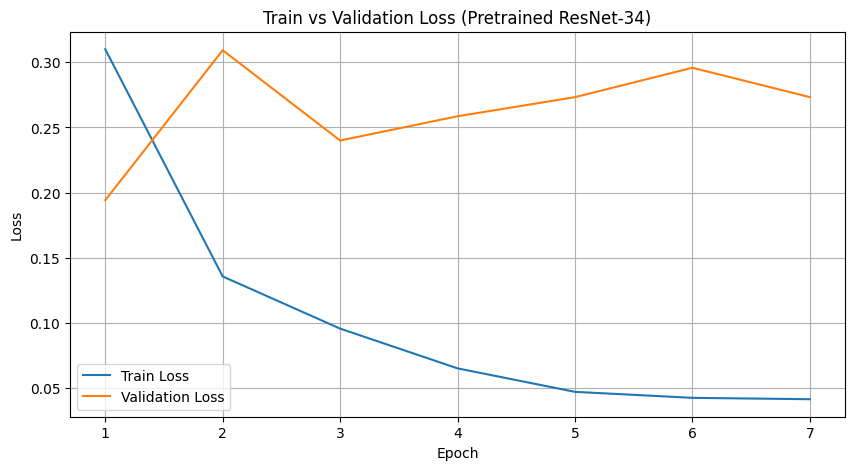

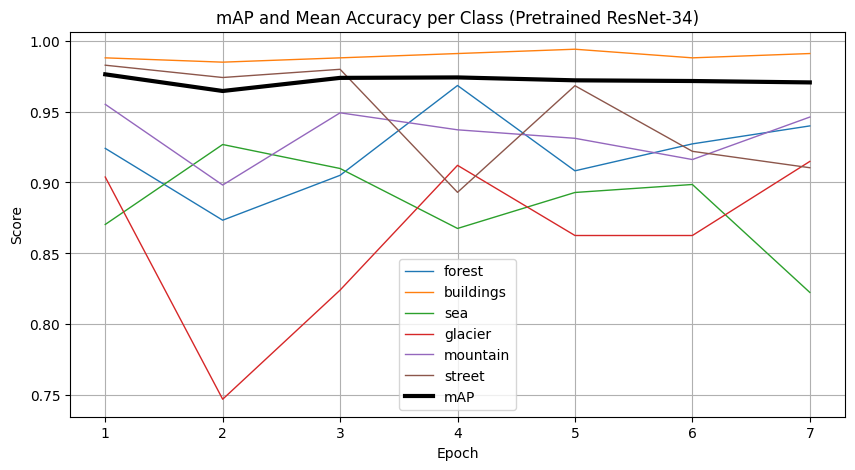

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accs) + 1)

# Train vs. Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss (Pretrained ResNet-34)")
plt.legend()
plt.grid(True)
plt.show()

# mAP and mean accuracy per class
plt.figure(figsize=(10, 5))
for i, cls in enumerate(classes):
    plt.plot(epochs, [epoch[i] for epoch in class_accs], linestyle='-', linewidth=1, label=f"{cls}")
plt.plot(epochs, map_scores, linestyle='-', linewidth=3, color='black', label="mAP")  # Tykkere sort linje for mAP
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("mAP and Mean Accuracy per Class (Pretrained ResNet-34)")
plt.legend()
plt.grid(True)
plt.show()
